# Setup

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import mmread
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import pyswarms as ps
import glob
import os

# Import data

In [2]:
# -----------------------------
# 1. Load 10x Genomics Data
# -----------------------------
# Adjust the file paths as needed:
matrix_path = "data/pbmc3k/filtered_gene_bc_matrices/hg19/matrix.mtx"
barcodes_path = "data/pbmc3k/filtered_gene_bc_matrices/hg19/barcodes.tsv"
genes_path = "data/pbmc3k/filtered_gene_bc_matrices/hg19/genes.tsv"  # or "features.tsv" in newer Cell Ranger versions

# Read barcodes and genes (not strictly needed for clustering, but useful to keep track)
barcodes = pd.read_csv(barcodes_path, header=None, sep='\t')
genes = pd.read_csv(genes_path, header=None, sep='\t')

# Read the sparse matrix
sparse_mtx = mmread(matrix_path)
# Transpose so rows = cells, columns = genes
# (Cell Ranger outputs columns=cells, but scRNA workflows often expect rows=cells)
sparse_mtx = sparse_mtx.T.tocsr()

# Convert to dense array (okay for ~3k cells x ~20k genes, but watch memory usage!)
X_dense = sparse_mtx.toarray()

In [13]:
sparse_mtx

<2700x32738 sparse matrix of type '<class 'numpy.float64'>'
	with 2286884 stored elements in Compressed Sparse Row format>

In [ ]:
# ----------------------------------------
# 1. Load PCA and t-SNE Projections
# ----------------------------------------
pca_df = pd.read_csv("data/pbmc3k/analysis/pca/projection.csv")
tsne_df = pd.read_csv("data/pbmc3k/analysis/tsne/projection.csv")

# ----------------------------------------
# 2. Load Each K-Means Clustering File
# ----------------------------------------
cluster_files = sorted(glob.glob("data/pbmc3k/analysis/kmeans/*_clusters/clusters.csv"))

In [6]:
pca_df.head()

,Barcode,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10
0,AAACATACAACCAC-1,-0.036339,-0.000549,0.000794,-0.017012,-0.003211,0.000438,0.004646,0.004670,0.006514,0.006905
1,AAACATTGAGCTAC-1,-0.008351,-0.011447,-0.015221,0.054502,0.008977,0.006034,0.001642,-0.006621,0.001067,-0.002333
2,AAACATTGATCAGC-1,-0.025257,0.011896,0.020833,-0.023106,0.011805,0.019217,-0.010754,-0.009297,-0.001191,-0.001945
3,AAACCGTGCTTCCG-1,0.081885,-0.015384,-0.003240,-0.003404,0.002646,0.015661,0.006271,-0.008011,-0.002094,0.001491
4,AAACCGTGTATGCG-1,0.020021,0.053305,0.068235,0.027632,-0.029962,-0.043100,0.029034,0.017645,-0.008180,0.008114


In [7]:
tsne_df.head()

,Barcode,TSNE-1,TSNE-2
0,AAACATACAACCAC-1,11.849575,-2.530312
1,AAACATTGAGCTAC-1,-5.155488,-28.677855
2,AAACATTGATCAGC-1,-4.761947,6.883890
3,AAACCGTGCTTCCG-1,-11.358188,27.867571
4,AAACCGTGTATGCG-1,-21.883776,-13.640626


In [34]:
clusters_df = pd.read_csv(cluster_files[4])
clusters_df.head()

,Barcode,Cluster
0,AAACATACAACCAC-1,2
1,AAACATTGAGCTAC-1,5
2,AAACATTGATCAGC-1,2
3,AAACCGTGCTTCCG-1,1
4,AAACCGTGTATGCG-1,3


# Old Analysis

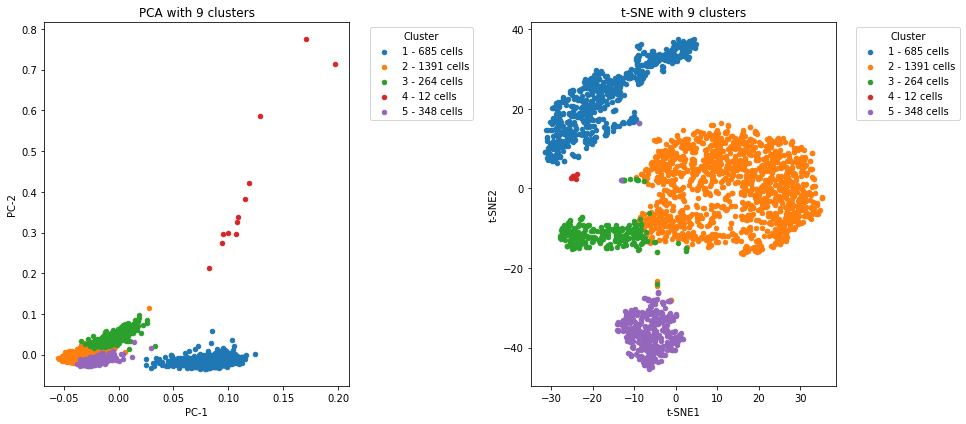

In [35]:
# ----------------------------------------
# 3. Merge with PCA and t-SNE Data
# ----------------------------------------
merged_pca = pd.merge(pca_df, clusters_df, on="Barcode", how="inner")
merged_tsne = pd.merge(tsne_df, clusters_df, on="Barcode", how="inner")

# ----------------------------------------
# 4. Plotting
# ----------------------------------------
# Increase figure width to make images broader
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Use a more distinct categorical palette (e.g., "tab10")
unique_clusters = sorted(merged_pca["Cluster"].unique())
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))

# ---------------------------
# (A) PCA Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_pca[merged_pca["Cluster"] == cluster_label]
    ax[0].scatter(
        subset["PC-1"], 
        subset["PC-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[0].set_title("PCA with 9 clusters")
ax[0].set_xlabel("PC-1")
ax[0].set_ylabel("PC-2")
ax[0].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# ---------------------------
# (B) t-SNE Scatter
# ---------------------------
for i, cluster_label in enumerate(unique_clusters):
    subset = merged_tsne[merged_tsne["Cluster"] == cluster_label]
    ax[1].scatter(
        subset["TSNE-1"], 
        subset["TSNE-2"],
        color=palette[i],
        s=20,
        label=f"{cluster_label} - {len(subset)} cells"
    )

ax[1].set_title("t-SNE with 9 clusters")
ax[1].set_xlabel("t-SNE1")
ax[1].set_ylabel("t-SNE2")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Cluster")

# Adjust layout to provide space for legends outside the axes
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

# New Analysis

PSO run time: 2.39 seconds
ABC run time: 2.72 seconds
ACOR run time: 2.62 seconds


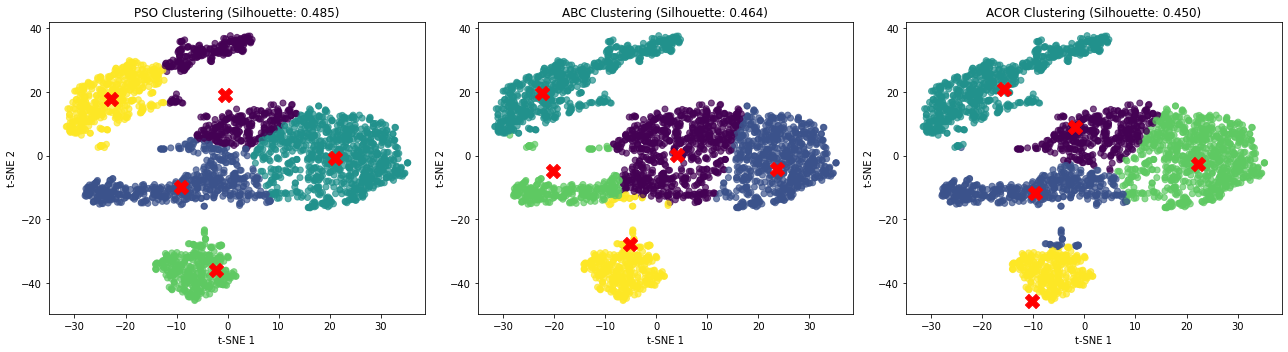

Clustering Comparison Results:
PSO: Cost = 296207.22, Silhouette Score = 0.485
ABC: Cost = 352484.65, Silhouette Score = 0.464
ACOR: Cost = 341355.76, Silhouette Score = 0.450


In [47]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import pyswarms as ps  # For PSO

# Assume tsne_df is a DataFrame with a 'Barcode' column and two t-SNE coordinate columns.
# Convert tsne_df to a numeric array (ignoring the 'Barcode'):
data_tsne = tsne_df.drop(columns=["Barcode"]).values  # shape: (n_cells, 2)

# -------------------------------
# 1. Define the clustering objective function
# -------------------------------
def clustering_objective_function(particles, data, n_clusters):
    """
    For each candidate solution (particle), compute the sum of squared distances
    of each data point to its nearest cluster center.
    Each particle is a flattened array of cluster centers.
    """
    n_particles = particles.shape[0]
    n_features = data.shape[1]
    cost = np.zeros(n_particles)
    
    for i in range(n_particles):
        centers = particles[i].reshape((n_clusters, n_features))
        distances = pairwise_distances(data, centers, metric='euclidean')
        min_distances = np.min(distances, axis=1)
        cost[i] = np.sum(min_distances**2)
    return cost

# -------------------------------
# 2. PSO Implementation (using pyswarms)
# -------------------------------
def run_pso(data_tsne, n_clusters, iters=100, n_particles=30):
    n_features = data_tsne.shape[1]  # 2 for t-SNE
    dimensions = n_clusters * n_features
    # Define bounds based on t-SNE data range
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    bounds = (lb, ub)
    
    options = {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, dimensions=dimensions,
                                        options=options, bounds=bounds)
    best_cost, best_pos = optimizer.optimize(clustering_objective_function,
                                             iters=iters,
                                             data=data_tsne,
                                             n_clusters=n_clusters,
                                             verbose=False)
    best_centers = best_pos.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

# -------------------------------
# 3. ABC Implementation (Artificial Bee Colony)
# -------------------------------
def run_abc(data_tsne, n_clusters, iters=100, n_food_sources=30, limit=20):
    n_features = data_tsne.shape[1]
    dimensions = n_clusters * n_features
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    
    # Initialize food sources randomly
    food_sources = np.random.uniform(low=lb, high=ub, size=(n_food_sources, dimensions))
    fitness = clustering_objective_function(food_sources, data_tsne, n_clusters)
    trial_counters = np.zeros(n_food_sources)
    
    best_index = np.argmin(fitness)
    best_solution = food_sources[best_index].copy()
    best_cost = fitness[best_index]
    
    for t in range(iters):
        # Employed bees phase
        for i in range(n_food_sources):
            # Select a random partner (different from i)
            j = np.random.randint(0, n_food_sources)
            while j == i:
                j = np.random.randint(0, n_food_sources)
            phi = np.random.uniform(-1, 1, size=dimensions)
            candidate = food_sources[i] + phi * (food_sources[i] - food_sources[j])
            candidate = np.clip(candidate, lb, ub)
            candidate_fitness = clustering_objective_function(candidate[np.newaxis, :], data_tsne, n_clusters)[0]
            if candidate_fitness < fitness[i]:
                food_sources[i] = candidate
                fitness[i] = candidate_fitness
                trial_counters[i] = 0
            else:
                trial_counters[i] += 1
        
        # Onlooker bees phase
        prob = (1.0 / (fitness + 1e-10))
        prob = prob / np.sum(prob)
        for i in range(n_food_sources):
            if np.random.rand() < prob[i]:
                j = np.random.randint(0, n_food_sources)
                while j == i:
                    j = np.random.randint(0, n_food_sources)
                phi = np.random.uniform(-1, 1, size=dimensions)
                candidate = food_sources[i] + phi * (food_sources[i] - food_sources[j])
                candidate = np.clip(candidate, lb, ub)
                candidate_fitness = clustering_objective_function(candidate[np.newaxis, :], data_tsne, n_clusters)[0]
                if candidate_fitness < fitness[i]:
                    food_sources[i] = candidate
                    fitness[i] = candidate_fitness
                    trial_counters[i] = 0
                else:
                    trial_counters[i] += 1
        
        # Scout phase: Reinitialize sources that haven't improved
        for i in range(n_food_sources):
            if trial_counters[i] > limit:
                food_sources[i] = np.random.uniform(low=lb, high=ub, size=dimensions)
                fitness[i] = clustering_objective_function(food_sources[i][np.newaxis, :], data_tsne, n_clusters)[0]
                trial_counters[i] = 0
        
        # Update best solution
        current_best_index = np.argmin(fitness)
        if fitness[current_best_index] < best_cost:
            best_cost = fitness[current_best_index]
            best_solution = food_sources[current_best_index].copy()
    
    best_centers = best_solution.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

# -------------------------------
# 4. ACOR Implementation (Ant Colony Optimization for Continuous Domains)
# -------------------------------
def run_acor(data_tsne, n_clusters, iters=100, archive_size=30, ants=30, q=0.5, xi=0.85):
    """
    ACOR: An Ant Colony Optimization algorithm adapted for continuous optimization.
    It maintains an archive of solutions and generates new solutions by Gaussian sampling.
    """
    n_features = data_tsne.shape[1]
    dimensions = n_clusters * n_features
    lb = np.min(data_tsne) * np.ones(dimensions)
    ub = np.max(data_tsne) * np.ones(dimensions)
    
    # Initialize archive with random solutions
    archive = np.random.uniform(low=lb, high=ub, size=(archive_size, dimensions))
    fitness = clustering_objective_function(archive, data_tsne, n_clusters)
    
    for t in range(iters):
        # Sort archive (best fitness first)
        sorted_idx = np.argsort(fitness)
        archive = archive[sorted_idx]
        fitness = fitness[sorted_idx]
        
        # Compute weights (Gaussian kernel based on rank)
        ranks = np.arange(archive_size)
        weights = (1 / (q * archive_size * np.sqrt(2 * np.pi))) * \
                  np.exp(- (ranks ** 2) / (2 * (q * archive_size) ** 2))
        weights = weights / np.sum(weights)
        
        # Compute standard deviations for Gaussian sampling
        sigma = np.zeros((archive_size, dimensions))
        for i in range(archive_size):
            diff = archive - archive[i]
            sigma[i] = xi * np.std(diff, axis=0)
            sigma[i][sigma[i] == 0] = 1e-6  # Prevent zero std
        
        # Generate new candidate solutions
        new_solutions = np.zeros((ants, dimensions))
        for i in range(ants):
            # Select a solution from archive using weighted probability
            idx = np.random.choice(np.arange(archive_size), p=weights)
            new_solution = np.random.normal(loc=archive[idx], scale=sigma[idx])
            new_solution = np.clip(new_solution, lb, ub)
            new_solutions[i] = new_solution
        
        new_fitness = clustering_objective_function(new_solutions, data_tsne, n_clusters)
        
        # Merge archive and new solutions, then keep the best 'archive_size' solutions
        combined = np.vstack((archive, new_solutions))
        combined_fitness = np.concatenate((fitness, new_fitness))
        sorted_idx = np.argsort(combined_fitness)
        archive = combined[sorted_idx][:archive_size]
        fitness = combined_fitness[sorted_idx][:archive_size]
    
    best_solution = archive[0]
    best_cost = fitness[0]
    best_centers = best_solution.reshape((n_clusters, n_features))
    distances = cdist(data_tsne, best_centers, metric='euclidean')
    labels = np.argmin(distances, axis=1)
    sil_score = silhouette_score(data_tsne, labels)
    return best_cost, best_centers, labels, sil_score

# -------------------------------
# 5. Run and Compare the Algorithms
# -------------------------------
n_clusters = 5
iters = 100

results = {}

# Run PSO
start = time.time()
pso_cost, pso_centers, pso_labels, pso_sil = run_pso(data_tsne, n_clusters, iters, n_particles=30)
results["PSO"] = {"cost": pso_cost, "silhouette": pso_sil}
print("PSO run time: {:.2f} seconds".format(time.time() - start))

# Run ABC
start = time.time()
abc_cost, abc_centers, abc_labels, abc_sil = run_abc(data_tsne, n_clusters, iters, n_food_sources=30, limit=20)
results["ABC"] = {"cost": abc_cost, "silhouette": abc_sil}
print("ABC run time: {:.2f} seconds".format(time.time() - start))

# Run ACOR (ACO variant)
start = time.time()
acor_cost, acor_centers, acor_labels, acor_sil = run_acor(data_tsne, n_clusters, iters, archive_size=30, ants=30, q=0.5, xi=0.85)
results["ACOR"] = {"cost": acor_cost, "silhouette": acor_sil}
print("ACOR run time: {:.2f} seconds".format(time.time() - start))

# -------------------------------
# 6. Visualization of Clustering Results
# -------------------------------
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=pso_labels, cmap='viridis', alpha=0.7)
plt.scatter(pso_centers[:, 0], pso_centers[:, 1], c='red', s=200, marker='X')
plt.title("PSO Clustering (Silhouette: {:.3f})".format(pso_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 3, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=abc_labels, cmap='viridis', alpha=0.7)
plt.scatter(abc_centers[:, 0], abc_centers[:, 1], c='red', s=200, marker='X')
plt.title("ABC Clustering (Silhouette: {:.3f})".format(abc_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.subplot(1, 3, 3)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=acor_labels, cmap='viridis', alpha=0.7)
plt.scatter(acor_centers[:, 0], acor_centers[:, 1], c='red', s=200, marker='X')
plt.title("ACOR Clustering (Silhouette: {:.3f})".format(acor_sil))
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

# -------------------------------
# 7. Print Comparison Summary
# -------------------------------
print("Clustering Comparison Results:")
for algo, res in results.items():
    print(f"{algo}: Cost = {res['cost']:.2f}, Silhouette Score = {res['silhouette']:.3f}")
